# Splitting parameters in Interchange

<details>
    <summary><small>▼ Click here for dependency installation instructions</small></summary>
    The simplest way to install dependencies is to use the Interchange examples environment. From the root of the cloned openff-interchange repository:
    
    conda env create --name interchange-examples --file devtools/conda-envs/examples_env.yaml
    conda activate interchange-examples
    pip install -e .
    cd examples/parameter_splitting
    jupyter notebook parameter_splitting.ipynb
    
</details>

This example explains splitting a single parameter applied to two different parts of a topology into two separate parameters.

In [1]:
import openmm
from openff.toolkit import Molecule, ForceField

from openff.interchange import Interchange
from openff.interchange.components.potentials import Potential
from openff.interchange.models import PotentialKey, TopologyKey

We need a molecule that has two parameters that are the same in Sage, but could reasonably be different. We'll pick the two Carbon-Carbon bonds in propanol. Let's set up our Interchange, store a copy of the original as an OpenMM system, and make sure we know what propanol looks like:

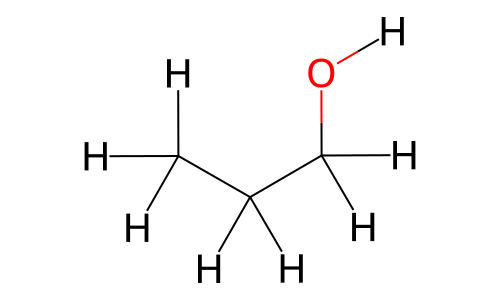

In [2]:
propanol = Molecule.from_smiles("CCCO")
propanol.generate_conformers(n_conformers=1)

sage = ForceField("openff-2.0.0.offxml")

interchange = Interchange.from_smirnoff(sage, topology=[propanol])

original_openmm_system = interchange.to_openmm()

propanol.visualize(backend="rdkit")

Interchange stores parameters in `PotentialHandler` objects. A potential handler maps atom indices to parameters via a `PotentialKey`, which identifies the parameters in the original force field (see [Tweaking and Inspecting Parameters]). We can see the atom indices of all the bonds and the corresponding potential keys by inspecting the `slot_map` attribute of the bonds potential handler:

[Tweaking and Inspecting Parameters]: https://openff-interchange.readthedocs.io/en/stable/using/handlers.html

In [3]:
interchange.handlers["Bonds"].slot_map

{TopologyKey(atom_indices=(0, 1), mult=None, bond_order=None): PotentialKey(id='[#6X4:1]-[#6X4:2]', mult=None, associated_handler='Bonds', bond_order=None),
 TopologyKey(atom_indices=(0, 4), mult=None, bond_order=None): PotentialKey(id='[#6X4:1]-[#1:2]', mult=None, associated_handler='Bonds', bond_order=None),
 TopologyKey(atom_indices=(0, 5), mult=None, bond_order=None): PotentialKey(id='[#6X4:1]-[#1:2]', mult=None, associated_handler='Bonds', bond_order=None),
 TopologyKey(atom_indices=(0, 6), mult=None, bond_order=None): PotentialKey(id='[#6X4:1]-[#1:2]', mult=None, associated_handler='Bonds', bond_order=None),
 TopologyKey(atom_indices=(1, 2), mult=None, bond_order=None): PotentialKey(id='[#6X4:1]-[#6X4:2]', mult=None, associated_handler='Bonds', bond_order=None),
 TopologyKey(atom_indices=(1, 7), mult=None, bond_order=None): PotentialKey(id='[#6X4:1]-[#1:2]', mult=None, associated_handler='Bonds', bond_order=None),
 TopologyKey(atom_indices=(1, 8), mult=None, bond_order=None): Pot

By iterating over the topology, we can pick out the C-C bonds. We'll need the potential key they both use, so let's give it a name:

In [4]:
for bond in interchange.topology.bonds:
    if all(atom.atomic_number == 6 for atom in bond.atoms):
        atom_indices = tuple(interchange.topology.atom_index(atom) for atom in bond.atoms)
        top_key = TopologyKey(atom_indices=atom_indices)
        pot_key = interchange.handlers["Bonds"].slot_map[top_key]
        print(atom_indices, pot_key.__repr__())

(0, 1) PotentialKey(id='[#6X4:1]-[#6X4:2]', mult=None, associated_handler='Bonds', bond_order=None)
(1, 2) PotentialKey(id='[#6X4:1]-[#6X4:2]', mult=None, associated_handler='Bonds', bond_order=None)


Notice that the `PotentialKey` associated with each of the C-C bonds - atom indices (0, 1) and (1, 2) - is the same, in this case associated with SMIRKS pattern `'[#6X4:1]-[#6X4:2]'`. This means the same parameters have been applied to each. For the sake of this example, let's consider splitting these parameters into two types without re-running SMIRKS/SMARTS-based atom-typing. Let's increase the force constant of the C-C bond nearest the O atom by 5% (atom indices (1, 2)). This is scientifically unmotivated; randomly changing a single force constant will not (usually) improve a force field.

## Creating a new potential

We'll start by cloning the existing C-C bond `PotentialKey`. The new ID can be anything as long as its unique, so let's choose something that makes the parameter's heritage clear without confusing ourselves with something that looks like a SMIRKS code:

In [5]:
pot_key_mod = PotentialKey(**pot_key.dict())
pot_key_mod.id = "[#6X4:1]-[#6X4:2]_MODIFIED"

(pot_key, pot_key_mod)

(PotentialKey(id='[#6X4:1]-[#6X4:2]', mult=None, associated_handler='Bonds', bond_order=None),
 PotentialKey(id='[#6X4:1]-[#6X4:2]_MODIFIED', mult=None, associated_handler='Bonds', bond_order=None))

Looks good! Now we need to do the same thing with the parameters themselves. We can get the potential out by indexing with the original `PontentialKey`, copy it, and then adjust it's force constant $k$:

In [6]:
pot = interchange.handlers["Bonds"].potentials[pot_key]
pot_mod = Potential(**pot.dict())
pot_mod.parameters["k"] *= 1.05

(pot, pot_mod)

(Potential(parameters={'k': <Quantity(529.242972, 'kilocalorie / angstrom ** 2 / mole')>, 'length': <Quantity(1.52190126, 'angstrom')>}, map_key=None),
 Potential(parameters={'k': <Quantity(555.70512, 'kilocalorie / angstrom ** 2 / mole')>, 'length': <Quantity(1.52190126, 'angstrom')>}, map_key=None))

Perfect. Now we add the new potential to the handler. This won't apply it anywhere in the topology, but it'll give us something to apply. The `.potentials` attribute is just a regular Python `dict` mapping potential keys to potentials, so we can use the regular Python `dict.update()` method with our modified key and potential:

In [7]:
interchange.handlers["Bonds"].potentials.update({pot_key_mod: pot_mod})

The last step is to apply it to the topology somewhere. Interchange identifies places in the topology by tuples of atom indices. We already decided that we want to apply our new potential to the bond between atoms 1 and 2, so we define a `TopologyKey` to that effect and check that the bond already exists (and is what we expect):

In [8]:
top_key = TopologyKey(atom_indices=(1, 2))

assert top_key in interchange["Bonds"].slot_map

interchange["Bonds"].slot_map[top_key]

PotentialKey(id='[#6X4:1]-[#6X4:2]', mult=None, associated_handler='Bonds', bond_order=None)

The `slot_map` attribute is another regular `dict` that maps a `TopologyKey` to a `PotentialKey`. Connecting the topology key (atom indices) to a potential key goes exactly how you'd expect:

In [9]:
interchange.handlers["Bonds"].slot_map[top_key] = pot_key_mod

## Testing our new parameter

To prove that we've done what we expected, let's export to OpenMM and use it's machinery to compare the force constants.

In [10]:
# Export to OpenMM
modified_openmm_system = interchange.to_openmm()

# Define the atom indices we care about
i = 1
j = 2

# Get the original exported k value
for force in original_openmm_system.getForces():
    if type(force) == openmm.HarmonicBondForce:
        for bond_idx in range(force.getNumBonds()):
            if force.getBondParameters(bond_idx)[:2] == [i, j]:
                original_k = force.getBondParameters(bond_idx)[3]
                print(f"K in the original system between atoms {i} and {j} is", original_k)

# Get the exported k value in the modified system
for force in modified_openmm_system.getForces():
    if type(force) == openmm.HarmonicBondForce:
        for bond_idx in range(force.getNumBonds()):
            if force.getBondParameters(bond_idx)[:2] == [i, j]:
                modified_k = force.getBondParameters(bond_idx)[3]
                print(f"K in the modified system between atoms {i} and {j} is", modified_k)

# Check that the modified k is 5% more than the original k
assert abs(modified_k / original_k - 1.05) < 1e-12
print(f"{modified_k}/{original_k} = {modified_k/original_k}")

K in the original system between atoms 1 and 2 is 221435.25929028585 kJ/(nm**2 mol)
K in the modified system between atoms 1 and 2 is 232507.02225480013 kJ/(nm**2 mol)
232507.02225480013 kJ/(nm**2 mol)/221435.25929028585 kJ/(nm**2 mol) = 1.05
